In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE


In [4]:
df = pd.read_csv("Churn_Modelling.csv")

In [5]:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [6]:
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])  # Female=0, Male=1
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

In [7]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

In [10]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [11]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [13]:
baseline = LogisticRegression()
baseline.fit(X_train, y_train)
y_val_pred = baseline.predict(X_val)

In [14]:
print("\n🔍 Baseline Model (Logistic Regression) Report:")
print(classification_report(y_val, y_val_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, baseline.predict_proba(X_val)[:, 1]))


🔍 Baseline Model (Logistic Regression) Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.38      0.67      0.49       407

    accuracy                           0.71      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.71      0.74      2000

ROC-AUC Score: 0.763447577006899


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(), 'accuracy'])

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

In [21]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks,
                    class_weight={0:1, 1:2},  # Example weight for imbalance
                    verbose=1)

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7665 - auc: 0.8684 - loss: 0.6285 - val_accuracy: 0.6720 - val_auc: 0.8491 - val_loss: 0.6039 - learning_rate: 5.0000e-04
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7715 - auc: 0.8701 - loss: 0.6242 - val_accuracy: 0.6785 - val_auc: 0.8492 - val_loss: 0.6073 - learning_rate: 5.0000e-04
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7628 - auc: 0.8670 - loss: 0.6336 - val_accuracy: 0.6730 - val_auc: 0.8474 - val_loss: 0.6134 - learning_rate: 5.0000e-04
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7725 - auc: 0.8728 - loss: 0.6233 - val_accuracy: 0.6770 - val_auc: 0.8465 - val_loss: 0.6042 - learning_rate: 5.0000e-04
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7627 - auc: 0.8669 - loss: 0.6370 - val_accuracy: 0.6825 - val_auc: 0.8485 - val_loss: 0.5975 - learning_rate: 2.5000e-04
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accura

In [22]:
val_results = model.evaluate(X_val, y_val, verbose=0)
print("\n✅ Neural Network Validation Results:")
print(f"Loss: {val_results[0]:.4f}, AUC: {val_results[1]:.4f}, Accuracy: {val_results[2]:.4f}")


✅ Neural Network Validation Results:
Loss: 0.5975, AUC: 0.8485, Accuracy: 0.6825


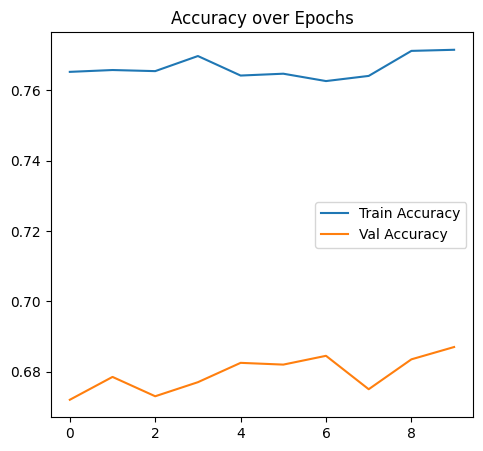

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()

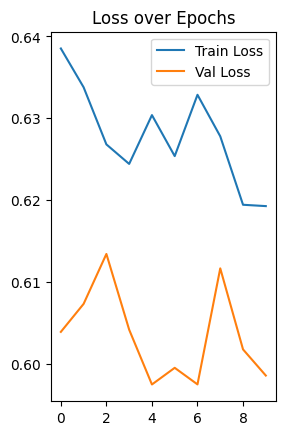

In [24]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()

In [25]:
print("\n🧪 Final Evaluation on Test Set:")
y_test_pred = model.predict(X_test).flatten()
y_test_labels = (y_test_pred >= 0.5).astype(int)
print(classification_report(y_test, y_test_labels))
print("ROC-AUC Score:", roc_auc_score(y_test, y_test_pred))


🧪 Final Evaluation on Test Set:
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      1593
           1       0.37      0.86      0.52       407

    accuracy                           0.67      2000
   macro avg       0.66      0.74      0.63      2000
weighted avg       0.83      0.67      0.70      2000

ROC-AUC Score: 0.8557494320206185


In [26]:
feature_names = X.columns
coefficients = baseline.coef_[0]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
importance_df.sort_values('Importance', key=abs, ascending=False, inplace=True)

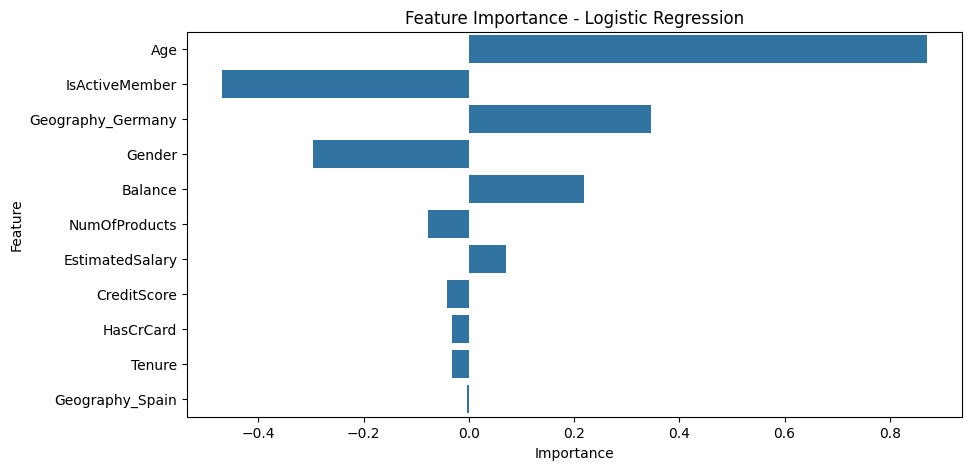

In [27]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance - Logistic Regression")
plt.show()